In [1]:
# Import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import os, shutil
import time
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

### USEFUL FUNCTIONS

In [2]:
import base64
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from sklearn import preprocessing


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = f"{name}-{tv}"
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(
        target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    # Regression
    return df[result].values.astype(np.float32), df[[target]].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"


# Regression chart.
def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(), label='expected')
    plt.plot(t['pred'].tolist(), label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean())
                          >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
        * (normalized_high - normalized_low) + normalized_low

In [3]:
# Load the data
train = pd.read_csv('Train.csv')

test = pd.read_csv('Test.csv')

sample_sub = pd.read_csv('sample_submission.csv')

variable_def = pd.read_csv('VariableDefinitions.csv')

In [4]:
# Preview the data
print('Train columns:', train.columns)
print('Shape of training data:', train.shape)
print('Shape of test set:', test.shape)
train.head()

Train columns: Index(['user_id', 'REGION', 'TENURE', 'MONTANT', 'FREQUENCE_RECH', 'REVENUE',
       'ARPU_SEGMENT', 'FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO',
       'ZONE1', 'ZONE2', 'MRG', 'REGULARITY', 'TOP_PACK', 'FREQ_TOP_PACK',
       'CHURN'],
      dtype='object')
Shape of training data: (400000, 19)
Shape of test set: (100000, 18)


,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,dcf68cc2fb515ccad7d8b9b3bd80ee2a4b270063,SAINT-LOUIS,K > 24 month,17000.0,32.0,18000.0,6000.0,34.0,NaN,97.0,355.0,6.0,NaN,NaN,NO,62,All-net 500F=2000F;5d,35.0,0
1,71c44b5ba328db5c4192a80f7cf8f244d9350ed0,NaN,K > 24 month,4300.0,29.0,4427.0,1476.0,37.0,1764.0,8.0,3.0,0.0,NaN,2.0,NO,40,"Data: 100 F=40MB,24H",22.0,0
2,ce46411b1526c94f20a383b8cb188f8d27f82a0a,TAMBACOUNDA,K > 24 month,1500.0,3.0,1500.0,500.0,3.0,NaN,30.0,30.0,NaN,NaN,NaN,NO,32,All-net 500F=2000F;5d,3.0,0
3,f467cdb6669818373c26c2bad44e01ba66f97d21,FATICK,K > 24 month,1500.0,3.0,2497.0,832.0,4.0,0.0,159.0,45.0,19.0,NaN,NaN,NO,18,On net 200F=Unlimited _call24H,3.0,0
4,ec45e1a1888a32b5dcce0954cfec20c6e037db31,FATICK,K > 24 month,NaN,NaN,498.0,166.0,3.0,1.0,1.0,3.0,NaN,NaN,NaN,NO,50,NaN,NaN,0


### FEATURE ENGINEERING AND EXPLORATORY DATA ANALYSIS

In [5]:
train.set_index('user_id', inplace=True)
test.set_index('user_id', inplace=True)

In [6]:
train.isnull().sum()

REGION            157520
TENURE                 0
MONTANT           140277
FREQUENCE_RECH    140277
REVENUE           134663
ARPU_SEGMENT      134663
FREQUENCE         134663
DATA_VOLUME       196854
ON_NET            145819
ORANGE            166317
TIGO              239386
ZONE1             368310
ZONE2             374487
MRG                    0
REGULARITY             0
TOP_PACK          167329
FREQ_TOP_PACK     167329
CHURN                  0
dtype: int64

### REGION

In [7]:
train['REGION'].isnull().sum()

157520

In [8]:
train['REGION'].value_counts()

DAKAR          95517
THIES          33374
SAINT-LOUIS    22125
LOUGA          18513
KAOLACK        18042
DIOURBEL       12576
TAMBACOUNDA    10273
KAFFRINE        8181
KOLDA           7204
FATICK          6638
MATAM           5255
ZIGUINCHOR      4012
SEDHIOU          589
KEDOUGOU         181
Name: REGION, dtype: int64

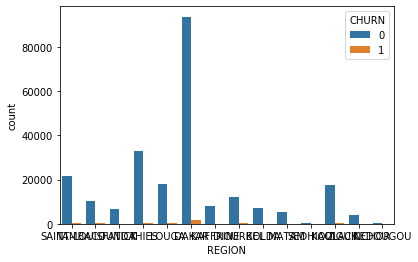

In [9]:
sns.countplot(x = 'REGION', hue='CHURN', data = train)

In [10]:
train['REGION'] = train['REGION'].fillna('DAKAR')
test['REGION'] = test['REGION'].fillna('DAKAR')

In [11]:
encode_text_dummy(train, name='REGION')
encode_text_dummy(test, name='REGION')


In [12]:
train.head(3)

,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,...,REGION-KAOLACK,REGION-KEDOUGOU,REGION-KOLDA,REGION-LOUGA,REGION-MATAM,REGION-SAINT-LOUIS,REGION-SEDHIOU,REGION-TAMBACOUNDA,REGION-THIES,REGION-ZIGUINCHOR
user_id,,,,,,,,,,,,,,,,,,,,,
dcf68cc2fb515ccad7d8b9b3bd80ee2a4b270063,K > 24 month,17000.0,32.0,18000.0,6000.0,34.0,NaN,97.0,355.0,6.0,...,0,0,0,0,0,1,0,0,0,0
71c44b5ba328db5c4192a80f7cf8f244d9350ed0,K > 24 month,4300.0,29.0,4427.0,1476.0,37.0,1764.0,8.0,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0
ce46411b1526c94f20a383b8cb188f8d27f82a0a,K > 24 month,1500.0,3.0,1500.0,500.0,3.0,NaN,30.0,30.0,NaN,...,0,0,0,0,0,0,0,1,0,0


### TENURE

In [13]:
train['TENURE'].value_counts()

K > 24 month     379439
I 18-21 month      8312
H 15-18 month      4858
G 12-15 month      2788
J 21-24 month      2325
F 9-12 month       1771
E 6-9 month         359
D 3-6 month         148
Name: TENURE, dtype: int64

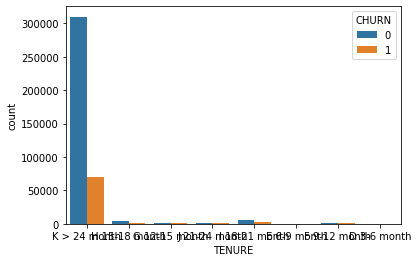

In [14]:
sns.countplot(x = 'TENURE', hue='CHURN', data = train)

In [15]:
def enco(data):
    if data == 'K > 24 month':
        out = 1
    else:
        out = 0
    return out

In [16]:
train['TENURE'] = train['TENURE'].apply(enco)
test['TENURE'] = test['TENURE'].apply(enco)

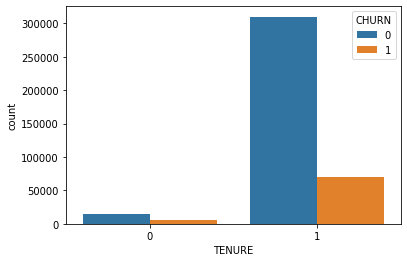

In [17]:
sns.countplot(x = 'TENURE', hue='CHURN', data = train)

### MONTANT

In [18]:
train['MONTANT'].describe()

count    259723.000000
mean       5522.971346
std        7099.640630
min          20.000000
25%        1000.000000
50%        3000.000000
75%        7300.000000
max      226550.000000
Name: MONTANT, dtype: float64

In [19]:
train['MONTANT'].isnull().sum()

140277

In [20]:
train['MONTANT'] = train['MONTANT'].fillna(train['MONTANT'].mode()[0])
test['MONTANT'] = test['MONTANT'].fillna(test['MONTANT'].mode()[0])

In [21]:
train['MONTANT'].value_counts()

500.0      161450
1000.0      15519
1500.0       8976
2000.0       8566
200.0        7545
            ...  
71000.0         1
77800.0         1
89550.0         1
2799.0          1
4096.0          1
Name: MONTANT, Length: 2421, dtype: int64

In [22]:
def bin_montant(data, min_val, max_val, range_val):
    data_copy = data.copy()
    range_of_vals = int(max_val+1 - min_val)
    batch_value = int(range_of_vals/range_val)
    dict_batch = {}
    start, stop = 0,0
    for i,j in enumerate(range(0,range_of_vals, batch_value)):
        stop = start + batch_value
        dict_batch[str(i)] = (start,stop)
        start = stop
        
        if stop <= range_of_vals:
            pass
        else:
            start = stop - batch_value
            stop = int(max_val) + 1
            
            dict_batch[str(i)] = (start,stop)
    print(dict_batch)       
    bin_out = []       
    for k in data_copy:
        out = [i for i,(start,stop) in zip(dict_batch.keys(), dict_batch.values()) if int(k) in range(start,stop)]
        #print(k,out)
        bin_out.append(int(out[0]))
    return bin_out


In [23]:
montant = bin_montant(train['MONTANT'], train['MONTANT'].min(), train['MONTANT'].max(), 30)
montant1 = bin_montant(test['MONTANT'], test['MONTANT'].min(), test['MONTANT'].max(), 30)

{'0': (0, 7551), '1': (7551, 15102), '2': (15102, 22653), '3': (22653, 30204), '4': (30204, 37755), '5': (37755, 45306), '6': (45306, 52857), '7': (52857, 60408), '8': (60408, 67959), '9': (67959, 75510), '10': (75510, 83061), '11': (83061, 90612), '12': (90612, 98163), '13': (98163, 105714), '14': (105714, 113265), '15': (113265, 120816), '16': (120816, 128367), '17': (128367, 135918), '18': (135918, 143469), '19': (143469, 151020), '20': (151020, 158571), '21': (158571, 166122), '22': (166122, 173673), '23': (173673, 181224), '24': (181224, 188775), '25': (188775, 196326), '26': (196326, 203877), '27': (203877, 211428), '28': (211428, 218979), '29': (218979, 226530), '30': (226530, 226551)}
{'0': (0, 6715), '1': (6715, 13430), '2': (13430, 20145), '3': (20145, 26860), '4': (26860, 33575), '5': (33575, 40290), '6': (40290, 47005), '7': (47005, 53720), '8': (53720, 60435), '9': (60435, 67150), '10': (67150, 73865), '11': (73865, 80580), '12': (80580, 87295), '13': (87295, 94010), '14':

In [24]:
train['MONTANT_BIN'] = montant
test['MONTANT_BIN'] = montant1

train.drop('MONTANT', inplace=True, axis=1)
test.drop('MONTANT', inplace=True, axis=1)

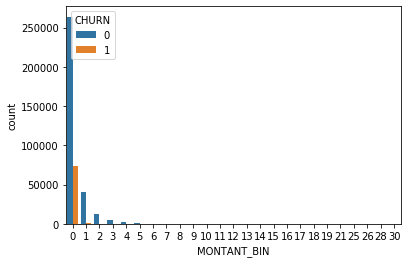

In [25]:
sns.countplot(x='MONTANT_BIN', hue='CHURN', data=train)

In [26]:
def enco(data):
    if data == 0:
        out = 1
    else:
        out = 0
    return out

train['MONTANT_BIN'] = train['MONTANT_BIN'].apply(enco)
test['MONTANT_BIN'] = test['MONTANT_BIN'].apply(enco)

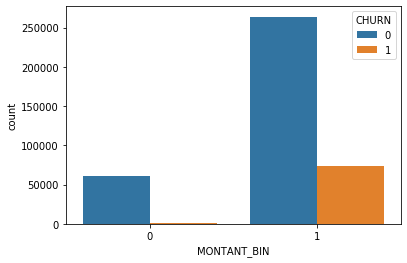

In [27]:
sns.countplot(x ='MONTANT_BIN', hue='CHURN', data = train)

### FREQUENCE_RECH

In [28]:
train['FREQUENCE_RECH'].describe()

count    259723.000000
mean         11.503733
std          13.275514
min           1.000000
25%           2.000000
50%           6.000000
75%          15.000000
max         133.000000
Name: FREQUENCE_RECH, dtype: float64

In [29]:
train['FREQUENCE_RECH'].isnull().sum()

140277

In [30]:
train['FREQUENCE_RECH'] = train['FREQUENCE_RECH'].fillna(train['FREQUENCE_RECH'].mean())
test['FREQUENCE_RECH'] = test['FREQUENCE_RECH'].fillna(test['FREQUENCE_RECH'].mean())


In [31]:
train['FREQUENCE_RECH'] = train['FREQUENCE_RECH'].round()
test['FREQUENCE_RECH'] = test['FREQUENCE_RECH'].round()

In [32]:
def bin_freq_rech(data, min_val, max_val, range_val):
    data_copy = data.copy()
    range_of_vals = int(max_val+1 - min_val)
    batch_value = int(range_of_vals/range_val)
    dict_batch = {}
    start, stop = 0,0
    for i,j in enumerate(range(0,range_of_vals, batch_value)):
        stop = start + batch_value
        dict_batch[str(i)] = (start,stop)
        start = stop
        
        if stop <= range_of_vals:
            pass
        else:
            start = stop - batch_value
            stop = int(max_val) + 1
            
            dict_batch[str(i)] = (start,stop)
    print(dict_batch)       
    bin_out = []       
    for k in data_copy:
        out = [i for i,(start,stop) in zip(dict_batch.keys(), dict_batch.values()) if int(k) in range(start,stop)]
        #print(k,out)
        bin_out.append(int(out[0]))
    return bin_out

In [33]:
freq_out = bin_freq_rech(train['FREQUENCE_RECH'], 1, 133, 10)
freq_out1 = bin_freq_rech(test['FREQUENCE_RECH'], 1, 120, 9)

{'0': (0, 13), '1': (13, 26), '2': (26, 39), '3': (39, 52), '4': (52, 65), '5': (65, 78), '6': (78, 91), '7': (91, 104), '8': (104, 117), '9': (117, 130), '10': (130, 134)}
{'0': (0, 13), '1': (13, 26), '2': (26, 39), '3': (39, 52), '4': (52, 65), '5': (65, 78), '6': (78, 91), '7': (91, 104), '8': (104, 117), '9': (117, 121)}


In [34]:
train['FREQ_BIN'] = freq_out
test['FREQ_BIN'] =freq_out1

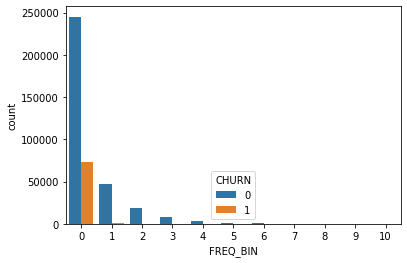

In [35]:
sns.countplot(x='FREQ_BIN', hue='CHURN', data=train)

In [36]:
def enco(data):
    if data == 0:
        out = 1
    else:
        out =0
    return out

In [37]:
train['FREQ_BIN'] = train['FREQ_BIN'].apply(enco)
test['FREQ_BIN'] = test['FREQ_BIN'].apply(enco)

In [38]:
train.drop('FREQUENCE_RECH', inplace=True, axis=1)
test.drop('FREQUENCE_RECH', inplace=True, axis=1)

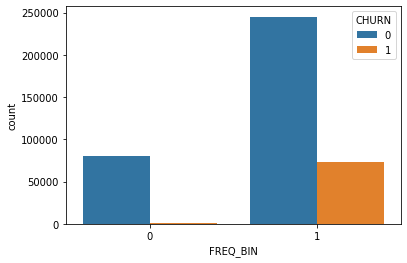

In [39]:
sns.countplot(x='FREQ_BIN', hue='CHURN', data=train)

#### REVENUE

In [40]:
train['REVENUE'].describe()

count    265337.000000
mean       5505.487757
std        7175.802367
min           1.000000
25%        1000.000000
50%        3000.000000
75%        7340.000000
max      233413.000000
Name: REVENUE, dtype: float64

In [41]:
train['REVENUE'].isnull().sum()

134663

In [42]:
train['REVENUE'] = train['REVENUE'].fillna(train['REVENUE'].mean())
test['REVENUE'] = test['REVENUE'].fillna(test['REVENUE'].mean())

In [43]:
train['REVENUE']

user_id
dcf68cc2fb515ccad7d8b9b3bd80ee2a4b270063    18000.000000
71c44b5ba328db5c4192a80f7cf8f244d9350ed0     4427.000000
ce46411b1526c94f20a383b8cb188f8d27f82a0a     1500.000000
f467cdb6669818373c26c2bad44e01ba66f97d21     2497.000000
ec45e1a1888a32b5dcce0954cfec20c6e037db31      498.000000
                                                ...     
a892ad4ed0eda8dc721733200c47147763b183ec      704.000000
13daa3a651bf0192a413b339c4766aeafc6d1636     5505.487757
767f596aee426962f7d92f4de8d7b232cdc17568      699.000000
b831e4d3b59a1e294e9e0a2aab391bc12d50845c        9.000000
a80e3a164986e489102cfb538fa62e16ecc28adf     5505.487757
Name: REVENUE, Length: 400000, dtype: float64

In [44]:
train['REVENUE'] = np.log1p(train['REVENUE'])
test['REVENUE'] = np.log1p(test['REVENUE'])

### ARPU_SEGMENT

In [45]:
train['ARPU_SEGMENT'].describe()

count    265337.000000
mean       1835.167658
std        2391.929290
min           0.000000
25%         333.000000
50%        1000.000000
75%        2447.000000
max       77804.000000
Name: ARPU_SEGMENT, dtype: float64

In [46]:
train['ARPU_SEGMENT'].isnull().sum()

134663

In [47]:
train['ARPU_SEGMENT'] = train['ARPU_SEGMENT'].fillna(train['ARPU_SEGMENT'].mean())
test['ARPU_SEGMENT'] = test['ARPU_SEGMENT'].fillna(test['ARPU_SEGMENT'].mean())

In [48]:
train['ARPU_SEGMENT'] = np.log1p(train['ARPU_SEGMENT'])
test['ARPU_SEGMENT'] = np.log1p(test['ARPU_SEGMENT'])

### FREQUENCE

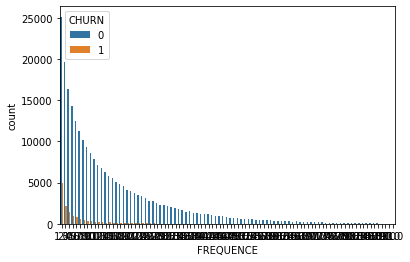

In [49]:
sns.countplot(x='FREQUENCE', hue='CHURN', data=train)
plt.show()

In [50]:
train['FREQUENCE'] = train['FREQUENCE'].fillna(train['FREQUENCE'].median())
test['FREQUENCE'] = test['FREQUENCE'].fillna(test['FREQUENCE'].median())

In [51]:
def bin_freq(data, min_val, max_val, range_val):
    data_copy = data.copy()
    range_of_vals = int(max_val+1 - min_val)
    batch_value = int(range_of_vals/range_val)
    dict_batch = {}
    start, stop = 0,0
    for i,j in enumerate(range(0,range_of_vals, batch_value)):
        stop = start + batch_value
        dict_batch[str(i)] = (start,stop)
        start = stop
        
        if stop <= range_of_vals:
            pass
        else:
            start = stop - batch_value
            stop = int(max_val) + 1
            
            dict_batch[str(i)] = (start,stop)
    print(dict_batch)       
    bin_out = []       
    for k in data_copy:
        out = [i for i,(start,stop) in zip(dict_batch.keys(), dict_batch.values()) if int(k) in range(start,stop)]
        #print(k,out)
        bin_out.append(int(out[0]))
    return bin_out


In [52]:
freq1 = bin_freq(train['FREQUENCE'], train['FREQUENCE'].min(), train['FREQUENCE'].max(), 9)
freq2 = bin_freq(test['FREQUENCE'], test['FREQUENCE'].min(), test['FREQUENCE'].max(), 9)

{'0': (0, 10), '1': (10, 20), '2': (20, 30), '3': (30, 40), '4': (40, 50), '5': (50, 60), '6': (60, 70), '7': (70, 80), '8': (80, 90), '9': (90, 92)}
{'0': (0, 10), '1': (10, 20), '2': (20, 30), '3': (30, 40), '4': (40, 50), '5': (50, 60), '6': (60, 70), '7': (70, 80), '8': (80, 90), '9': (90, 92)}


In [53]:
train['FREQ_BIN'] = freq1
test['FREQ_BIN'] = freq2

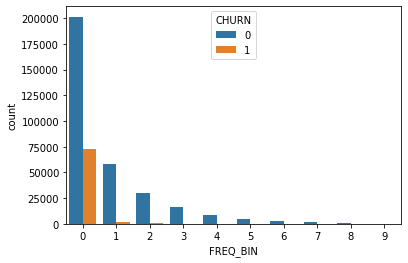

In [54]:
sns.countplot(x='FREQ_BIN', hue='CHURN', data=train)

In [55]:
def enco(data):
    if data == 0:
        out = 1
    elif data == 1:
        out = 1
    else:
        out = 0
    return out

In [56]:
train['FREQ_BIN'] = train['FREQ_BIN'].apply(enco)
test['FREQ_BIN'] = test['FREQ_BIN'].apply(enco)

In [57]:
train.drop('FREQUENCE', inplace=True, axis =1)
test.drop('FREQUENCE', inplace=True, axis =1)

### DATA_VOLUME

In [58]:
train['DATA_VOLUME'].isna().sum()

196854

In [59]:
train['DATA_VOLUME'] = train['DATA_VOLUME'].fillna(train['DATA_VOLUME'].median())
test['DATA_VOLUME'] = test['DATA_VOLUME'].fillna(test['DATA_VOLUME'].median())

In [60]:
train['DATA_VOLUME'] = np.log1p(train['DATA_VOLUME'])
test['DATA_VOLUME'] = np.log1p(test['DATA_VOLUME'])

### ON_NET

In [61]:
train['ON_NET'] = train['ON_NET'].fillna(train['ON_NET'].median())
test['ON_NET'] = test['ON_NET'].fillna(test['ON_NET'].median())

In [62]:
train['ON_NET']= np.log1p(train['ON_NET'])
test['ON_NET']= np.log1p(test['ON_NET'])


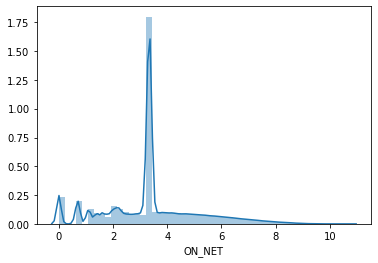

In [63]:
sns.distplot(train['ON_NET'])

### ORANGE

In [64]:
train['ORANGE'] = train['ORANGE'].fillna(train['ORANGE'].median())
test['ORANGE'] = test['ORANGE'].fillna(test['ORANGE'].median())

In [65]:
train['ORANGE'] = np.log1p(train['ORANGE'])
test['ORANGE'] = np.log1p(test['ORANGE'])

In [66]:
def bin_orange(data, min_val, max_val, range_val):
    data_copy = data.copy()
    range_of_vals = int(max_val+1 - min_val)
    batch_value = int(range_of_vals/range_val)
    dict_batch = {}
    start, stop = 0,0
    for i,j in enumerate(range(0,range_of_vals, batch_value)):
        stop = start + batch_value
        dict_batch[str(i)] = (start,stop)
        start = stop
        
        if stop <= range_of_vals:
            pass
        else:
            start = stop - batch_value
            stop = int(max_val) + 1
            
            dict_batch[str(i)] = (start,stop)
    print(dict_batch)       
    bin_out = []       
    for k in data_copy:
        out = [i for i,(start,stop) in zip(dict_batch.keys(), dict_batch.values()) if int(k) in range(start,stop)]
        #print(k,out)
        bin_out.append(int(out[0]))
    return bin_out


In [67]:
orange = bin_orange(train['ORANGE'], train['ORANGE'].min(), train['ORANGE'].max(), 8)
orange1 = bin_orange(test['ORANGE'], test['ORANGE'].min(), test['ORANGE'].max(), 8)

{'0': (0, 1), '1': (1, 2), '2': (2, 3), '3': (3, 4), '4': (4, 5), '5': (5, 6), '6': (6, 7), '7': (7, 8), '8': (8, 9)}
{'0': (0, 1), '1': (1, 2), '2': (2, 3), '3': (3, 4), '4': (4, 5), '5': (5, 6), '6': (6, 7), '7': (7, 8), '8': (8, 9)}


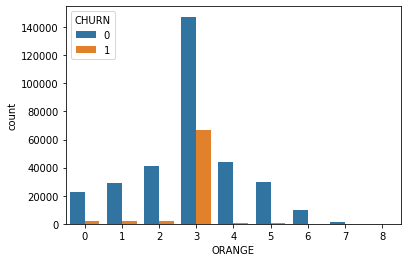

In [68]:
train['ORANGE'] = orange
test['ORANGE'] = orange1
sns.countplot(x=train['ORANGE'], hue='CHURN', data=train)

### TIGO

In [69]:
train['TIGO'] = train['TIGO'].fillna(train['TIGO'].mean())
test['TIGO'] = test['TIGO'].fillna(test['TIGO'].mean())

In [70]:
train['TIGO'] = np.round(train['TIGO'])
test['TIGO'] = np.round(test['TIGO'])

In [71]:
train['TIGO'].value_counts()

23.0      240662
1.0        20808
0.0        17828
2.0        13450
3.0         9910
           ...  
419.0          1
1602.0         1
926.0          1
1219.0         1
568.0          1
Name: TIGO, Length: 805, dtype: int64

In [72]:
def bin_tigo(data, min_val, max_val, range_val):
    data_copy = data.copy()
    range_of_vals = int(max_val+1 - min_val)
    batch_value = int(range_of_vals/range_val)
    dict_batch = {}
    start, stop = 0,0
    for i,j in enumerate(range(0,range_of_vals, batch_value)):
        stop = start + batch_value
        dict_batch[str(i)] = (start,stop)
        start = stop
        
        if stop <= range_of_vals:
            pass
        else:
            start = stop - batch_value
            stop = int(max_val) + 1
            
            dict_batch[str(i)] = (start,stop)
    print(dict_batch)       
    bin_out = []       
    for k in data_copy:
        out = [i for i,(start,stop) in zip(dict_batch.keys(), dict_batch.values()) if int(k) in range(start,stop)]
        #print(k,out)
        bin_out.append(int(out[0]))
    return bin_out


In [73]:
tigo = bin_tigo(train['TIGO'], train['TIGO'].min(), train['TIGO'].max(), 10)
tigo1 = bin_tigo(test['TIGO'], test['TIGO'].min(), test['TIGO'].max(), 10)

{'0': (0, 275), '1': (275, 550), '2': (550, 825), '3': (825, 1100), '4': (1100, 1375), '5': (1375, 1650), '6': (1650, 1925), '7': (1925, 2200), '8': (2200, 2475), '9': (2475, 2750), '10': (2750, 2759)}
{'0': (0, 308), '1': (308, 616), '2': (616, 924), '3': (924, 1232), '4': (1232, 1540), '5': (1540, 1848), '6': (1848, 2156), '7': (2156, 2464), '8': (2464, 2772), '9': (2772, 3080), '10': (3080, 3084)}


In [74]:
train['TIGO'] = tigo
test['TIGO'] = tigo1

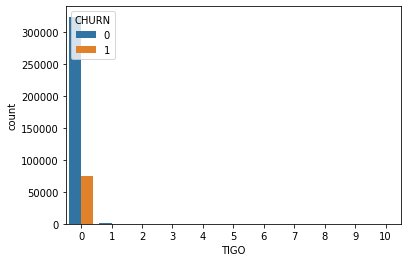

In [75]:
sns.countplot(x=train['TIGO'], hue='CHURN', data=train)

In [76]:
def enco(data):
    if data == 0:
        out = 1
    else:
        out = 0
    return out

train['TIGO'] = train['TIGO'].apply(enco)
test['TIGO'] = test['TIGO'].apply(enco)

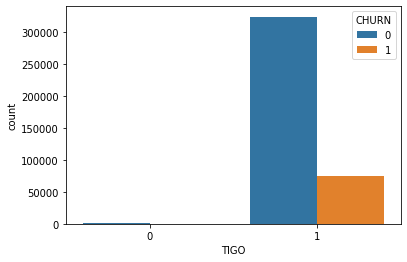

In [77]:
sns.countplot(x='TIGO', hue='CHURN', data=train)

In [78]:
to_drop1 = ['ZONE1', 'ZONE2', 'MRG']

train.drop(to_drop1, inplace=True, axis=1)
test.drop(to_drop1, inplace=True, axis=1)

### REGULARITY

In [79]:
def bin_regu(data, min_val, max_val, range_val):
    data_copy = data.copy()
    range_of_vals = int(max_val+1 - min_val)
    batch_value = int(range_of_vals/range_val)
    dict_batch = {}
    start, stop = 0,0
    for i,j in enumerate(range(0,range_of_vals, batch_value)):
        stop = start + batch_value
        dict_batch[str(i)] = (start,stop)
        start = stop
        
        if stop <= range_of_vals:
            pass
        else:
            start = stop - batch_value
            stop = int(max_val) + 1
            
            dict_batch[str(i)] = (start,stop)
    print(dict_batch)       
    bin_out = []       
    for k in data_copy:
        out = [i for i,(start,stop) in zip(dict_batch.keys(), dict_batch.values()) if int(k) in range(start,stop)]
        #print(k,out)
        bin_out.append(int(out[0]))
    return bin_out


In [80]:
regu = bin_regu(train['REGULARITY'], train['REGULARITY'].min(), train['REGULARITY'].max(), 6)
regu1 = bin_regu(test['REGULARITY'], test['REGULARITY'].min(), test['REGULARITY'].max(), 6)

{'0': (0, 10), '1': (10, 20), '2': (20, 30), '3': (30, 40), '4': (40, 50), '5': (50, 60), '6': (60, 63)}
{'0': (0, 10), '1': (10, 20), '2': (20, 30), '3': (30, 40), '4': (40, 50), '5': (50, 60), '6': (60, 63)}


In [81]:
train['REGULARITY'] = regu
test['REGULARITY'] = regu1


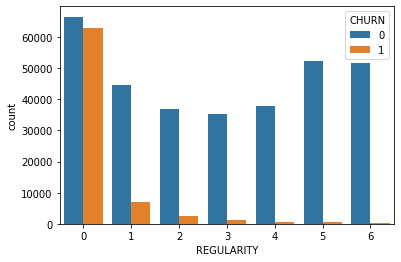

In [82]:
sns.countplot(x='REGULARITY', hue='CHURN', data=train)

### TOP_PACK

In [83]:
train.drop('TOP_PACK', axis=1, inplace=True)
test.drop('TOP_PACK', axis=1, inplace=True)

### FREQ_TOP_PACK

In [84]:
train['FREQ_TOP_PACK'].fillna(train['FREQ_TOP_PACK'].mean(), inplace=True)
test['FREQ_TOP_PACK'].fillna(test['FREQ_TOP_PACK'].mean(), inplace=True)

In [85]:
train.isnull().sum()

TENURE                0
REVENUE               0
ARPU_SEGMENT          0
DATA_VOLUME           0
ON_NET                0
ORANGE                0
TIGO                  0
REGULARITY            0
FREQ_TOP_PACK         0
CHURN                 0
REGION-DAKAR          0
REGION-DIOURBEL       0
REGION-FATICK         0
REGION-KAFFRINE       0
REGION-KAOLACK        0
REGION-KEDOUGOU       0
REGION-KOLDA          0
REGION-LOUGA          0
REGION-MATAM          0
REGION-SAINT-LOUIS    0
REGION-SEDHIOU        0
REGION-TAMBACOUNDA    0
REGION-THIES          0
REGION-ZIGUINCHOR     0
MONTANT_BIN           0
FREQ_BIN              0
dtype: int64

In [86]:
train_copy = train.copy()
train.shape

(400000, 26)

In [87]:
# Extract the Feature Vectors and Target
y = train['CHURN'].values
train.drop('CHURN', inplace=True, axis=1)
X = train.values
test_data = test.values

In [101]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold

boot = StratifiedKFold(n_splits=10)
score = []
# Loop through samples
for train, test in boot.split(X, y):
    start_time = time.time()
    num+=1

    # Split train and test
    x_train = X[train]
    y_train = y[train]
    x_test = X[test]
    y_test = y[test]
    
    cat = CatBoostClassifier(depth=16, learning_rate=0.1, n_estimators=1000)
    cat.fit(x_train, y_train, early_stopping_rounds = 100,eval_set=(x_test, y_test), use_best_model=True)
    score.append(cat.score(x_test, y_test))

0:	learn: 0.5631774	test: 0.5633116	best: 0.5633116 (0)	total: 10.2s	remaining: 2h 49m 55s
1:	learn: 0.4766136	test: 0.4764721	best: 0.4764721 (1)	total: 17s	remaining: 2h 21m 31s
2:	learn: 0.4205720	test: 0.4202920	best: 0.4202920 (2)	total: 23.6s	remaining: 2h 10m 30s
3:	learn: 0.3824787	test: 0.3820434	best: 0.3820434 (3)	total: 25.8s	remaining: 1h 46m 54s
4:	learn: 0.3558222	test: 0.3553859	best: 0.3553859 (4)	total: 32.1s	remaining: 1h 46m 34s
5:	learn: 0.3373493	test: 0.3367997	best: 0.3367997 (5)	total: 38.5s	remaining: 1h 46m 13s
6:	learn: 0.3243397	test: 0.3236489	best: 0.3236489 (6)	total: 40.6s	remaining: 1h 36m 5s
7:	learn: 0.3150401	test: 0.3141184	best: 0.3141184 (7)	total: 40.8s	remaining: 1h 24m 23s
8:	learn: 0.3079580	test: 0.3071366	best: 0.3071366 (8)	total: 47.5s	remaining: 1h 27m 9s
9:	learn: 0.3025619	test: 0.3016769	best: 0.3016769 (9)	total: 54.1s	remaining: 1h 29m 12s
10:	learn: 0.2981278	test: 0.2973914	best: 0.2973914 (10)	total: 1m 1s	remaining: 1h 31m 24s
1

88:	learn: 0.2716654	test: 0.2824296	best: 0.2819634 (45)	total: 9m 19s	remaining: 1h 35m 30s
89:	learn: 0.2714921	test: 0.2824593	best: 0.2819634 (45)	total: 9m 26s	remaining: 1h 35m 30s
90:	learn: 0.2714905	test: 0.2824578	best: 0.2819634 (45)	total: 9m 26s	remaining: 1h 34m 22s
91:	learn: 0.2713485	test: 0.2824774	best: 0.2819634 (45)	total: 9m 33s	remaining: 1h 34m 21s
92:	learn: 0.2712721	test: 0.2824891	best: 0.2819634 (45)	total: 9m 40s	remaining: 1h 34m 19s
93:	learn: 0.2711737	test: 0.2824978	best: 0.2819634 (45)	total: 9m 47s	remaining: 1h 34m 17s
94:	learn: 0.2711337	test: 0.2825319	best: 0.2819634 (45)	total: 9m 53s	remaining: 1h 34m 16s
95:	learn: 0.2710046	test: 0.2825533	best: 0.2819634 (45)	total: 10m	remaining: 1h 34m 13s
96:	learn: 0.2709249	test: 0.2825595	best: 0.2819634 (45)	total: 10m 7s	remaining: 1h 34m 12s
97:	learn: 0.2707816	test: 0.2825841	best: 0.2819634 (45)	total: 10m 14s	remaining: 1h 34m 12s
98:	learn: 0.2706676	test: 0.2826204	best: 0.2819634 (45)	tota

28:	learn: 0.2792718	test: 0.2885572	best: 0.2885217 (27)	total: 2m 37s	remaining: 1h 28m
29:	learn: 0.2789833	test: 0.2884993	best: 0.2884993 (29)	total: 2m 43s	remaining: 1h 28m 22s
30:	learn: 0.2786528	test: 0.2884615	best: 0.2884615 (30)	total: 2m 50s	remaining: 1h 28m 44s
31:	learn: 0.2784382	test: 0.2884661	best: 0.2884615 (30)	total: 2m 56s	remaining: 1h 29m 2s
32:	learn: 0.2782470	test: 0.2884419	best: 0.2884419 (32)	total: 3m 2s	remaining: 1h 29m 18s
33:	learn: 0.2781057	test: 0.2884371	best: 0.2884371 (33)	total: 3m 9s	remaining: 1h 29m 32s
34:	learn: 0.2778661	test: 0.2884300	best: 0.2884300 (34)	total: 3m 15s	remaining: 1h 29m 47s
35:	learn: 0.2776958	test: 0.2884626	best: 0.2884300 (34)	total: 3m 21s	remaining: 1h 30m
36:	learn: 0.2774753	test: 0.2885088	best: 0.2884300 (34)	total: 3m 28s	remaining: 1h 30m 17s
37:	learn: 0.2772380	test: 0.2885048	best: 0.2884300 (34)	total: 3m 34s	remaining: 1h 30m 21s
38:	learn: 0.2770641	test: 0.2885165	best: 0.2884300 (34)	total: 3m 40s

116:	learn: 0.2681505	test: 0.2899249	best: 0.2884300 (34)	total: 17m 50s	remaining: 2h 14m 35s
117:	learn: 0.2681477	test: 0.2899197	best: 0.2884300 (34)	total: 17m 50s	remaining: 2h 13m 20s
118:	learn: 0.2680468	test: 0.2899478	best: 0.2884300 (34)	total: 18m 3s	remaining: 2h 13m 38s
119:	learn: 0.2679911	test: 0.2899886	best: 0.2884300 (34)	total: 18m 16s	remaining: 2h 13m 57s
120:	learn: 0.2679067	test: 0.2899872	best: 0.2884300 (34)	total: 18m 28s	remaining: 2h 14m 9s
121:	learn: 0.2677299	test: 0.2900616	best: 0.2884300 (34)	total: 18m 40s	remaining: 2h 14m 24s
122:	learn: 0.2676571	test: 0.2900741	best: 0.2884300 (34)	total: 18m 52s	remaining: 2h 14m 34s
123:	learn: 0.2675776	test: 0.2901172	best: 0.2884300 (34)	total: 19m 4s	remaining: 2h 14m 45s
124:	learn: 0.2674609	test: 0.2901369	best: 0.2884300 (34)	total: 19m 16s	remaining: 2h 14m 55s
125:	learn: 0.2672400	test: 0.2902099	best: 0.2884300 (34)	total: 19m 28s	remaining: 2h 15m 4s
126:	learn: 0.2670227	test: 0.2902846	best: 

67:	learn: 0.2726403	test: 0.2881418	best: 0.2876663 (37)	total: 12m	remaining: 2h 44m 33s
68:	learn: 0.2725738	test: 0.2881396	best: 0.2876663 (37)	total: 12m 13s	remaining: 2h 44m 55s
69:	learn: 0.2725161	test: 0.2881604	best: 0.2876663 (37)	total: 12m 26s	remaining: 2h 45m 19s
70:	learn: 0.2723255	test: 0.2881648	best: 0.2876663 (37)	total: 12m 38s	remaining: 2h 45m 27s
71:	learn: 0.2721794	test: 0.2881702	best: 0.2876663 (37)	total: 12m 50s	remaining: 2h 45m 37s
72:	learn: 0.2720677	test: 0.2881996	best: 0.2876663 (37)	total: 13m 2s	remaining: 2h 45m 36s
73:	learn: 0.2719492	test: 0.2882182	best: 0.2876663 (37)	total: 13m 15s	remaining: 2h 45m 50s
74:	learn: 0.2717846	test: 0.2882261	best: 0.2876663 (37)	total: 13m 27s	remaining: 2h 46m 1s
75:	learn: 0.2716499	test: 0.2882639	best: 0.2876663 (37)	total: 13m 40s	remaining: 2h 46m 16s
76:	learn: 0.2716122	test: 0.2882572	best: 0.2876663 (37)	total: 13m 52s	remaining: 2h 46m 22s
77:	learn: 0.2714806	test: 0.2882802	best: 0.2876663 (37

15:	learn: 0.2872030	test: 0.2899071	best: 0.2899071 (15)	total: 1m 13s	remaining: 1h 15m 7s
16:	learn: 0.2861040	test: 0.2890480	best: 0.2890480 (16)	total: 1m 20s	remaining: 1h 17m 43s
17:	learn: 0.2850086	test: 0.2883397	best: 0.2883397 (17)	total: 1m 28s	remaining: 1h 20m 1s
18:	learn: 0.2842527	test: 0.2877997	best: 0.2877997 (18)	total: 1m 35s	remaining: 1h 21m 59s
19:	learn: 0.2836763	test: 0.2872365	best: 0.2872365 (19)	total: 1m 35s	remaining: 1h 18m 12s
20:	learn: 0.2830379	test: 0.2868117	best: 0.2868117 (20)	total: 1m 43s	remaining: 1h 20m 11s
21:	learn: 0.2828439	test: 0.2866155	best: 0.2866155 (21)	total: 1m 43s	remaining: 1h 16m 32s
22:	learn: 0.2823620	test: 0.2863755	best: 0.2863755 (22)	total: 1m 50s	remaining: 1h 18m 4s
23:	learn: 0.2816912	test: 0.2860891	best: 0.2860891 (23)	total: 1m 57s	remaining: 1h 19m 29s
24:	learn: 0.2812362	test: 0.2859311	best: 0.2859311 (24)	total: 2m 4s	remaining: 1h 20m 43s
25:	learn: 0.2807847	test: 0.2858361	best: 0.2858361 (25)	total:

103:	learn: 0.2694543	test: 0.2860695	best: 0.2852495 (43)	total: 15m 11s	remaining: 2h 10m 53s
104:	learn: 0.2693763	test: 0.2860634	best: 0.2852495 (43)	total: 15m 23s	remaining: 2h 11m 14s
105:	learn: 0.2692491	test: 0.2860960	best: 0.2852495 (43)	total: 15m 35s	remaining: 2h 11m 34s
106:	learn: 0.2692067	test: 0.2860982	best: 0.2852495 (43)	total: 15m 47s	remaining: 2h 11m 45s
107:	learn: 0.2690491	test: 0.2861172	best: 0.2852495 (43)	total: 15m 59s	remaining: 2h 12m 7s
108:	learn: 0.2689519	test: 0.2861741	best: 0.2852495 (43)	total: 16m 12s	remaining: 2h 12m 26s
109:	learn: 0.2687923	test: 0.2862063	best: 0.2852495 (43)	total: 16m 24s	remaining: 2h 12m 43s
110:	learn: 0.2687494	test: 0.2862142	best: 0.2852495 (43)	total: 16m 35s	remaining: 2h 12m 53s
111:	learn: 0.2686609	test: 0.2862128	best: 0.2852495 (43)	total: 16m 47s	remaining: 2h 13m 5s
112:	learn: 0.2685744	test: 0.2862376	best: 0.2852495 (43)	total: 16m 59s	remaining: 2h 13m 21s
113:	learn: 0.2684625	test: 0.2862325	best

45:	learn: 0.2764453	test: 0.2847724	best: 0.2847724 (45)	total: 7m 40s	remaining: 2h 39m 7s
46:	learn: 0.2762615	test: 0.2847490	best: 0.2847490 (46)	total: 7m 51s	remaining: 2h 39m 24s
47:	learn: 0.2761293	test: 0.2847184	best: 0.2847184 (47)	total: 8m 2s	remaining: 2h 39m 32s
48:	learn: 0.2760679	test: 0.2847243	best: 0.2847184 (47)	total: 8m 3s	remaining: 2h 36m 24s
49:	learn: 0.2759293	test: 0.2846956	best: 0.2846956 (49)	total: 8m 14s	remaining: 2h 36m 41s
50:	learn: 0.2756754	test: 0.2846899	best: 0.2846899 (50)	total: 8m 26s	remaining: 2h 37m 1s
51:	learn: 0.2755510	test: 0.2847076	best: 0.2846899 (50)	total: 8m 37s	remaining: 2h 37m 19s
52:	learn: 0.2754445	test: 0.2847026	best: 0.2846899 (50)	total: 8m 49s	remaining: 2h 37m 42s
53:	learn: 0.2752423	test: 0.2847132	best: 0.2846899 (50)	total: 9m	remaining: 2h 37m 49s
54:	learn: 0.2751239	test: 0.2847390	best: 0.2846899 (50)	total: 9m 12s	remaining: 2h 38m 15s
55:	learn: 0.2749449	test: 0.2847380	best: 0.2846899 (50)	total: 9m 

134:	learn: 0.2654016	test: 0.2858264	best: 0.2846899 (50)	total: 24m 25s	remaining: 2h 36m 30s
135:	learn: 0.2652033	test: 0.2858679	best: 0.2846899 (50)	total: 24m 38s	remaining: 2h 36m 34s
136:	learn: 0.2651018	test: 0.2859128	best: 0.2846899 (50)	total: 24m 51s	remaining: 2h 36m 35s
137:	learn: 0.2651013	test: 0.2859117	best: 0.2846899 (50)	total: 24m 51s	remaining: 2h 35m 18s
138:	learn: 0.2650083	test: 0.2859251	best: 0.2846899 (50)	total: 25m 4s	remaining: 2h 35m 18s
139:	learn: 0.2648302	test: 0.2859462	best: 0.2846899 (50)	total: 25m 16s	remaining: 2h 35m 13s
140:	learn: 0.2646361	test: 0.2859769	best: 0.2846899 (50)	total: 25m 28s	remaining: 2h 35m 13s
141:	learn: 0.2644281	test: 0.2859630	best: 0.2846899 (50)	total: 25m 41s	remaining: 2h 35m 15s
142:	learn: 0.2642820	test: 0.2859960	best: 0.2846899 (50)	total: 25m 54s	remaining: 2h 35m 16s
143:	learn: 0.2641309	test: 0.2860129	best: 0.2846899 (50)	total: 26m 7s	remaining: 2h 35m 18s
144:	learn: 0.2639576	test: 0.2860114	best

70:	learn: 0.2732481	test: 0.2838031	best: 0.2837683 (58)	total: 9m 25s	remaining: 2h 3m 14s
71:	learn: 0.2732476	test: 0.2838029	best: 0.2837683 (58)	total: 9m 25s	remaining: 2h 1m 24s
72:	learn: 0.2731170	test: 0.2838200	best: 0.2837683 (58)	total: 9m 31s	remaining: 2h 1m
73:	learn: 0.2730740	test: 0.2838122	best: 0.2837683 (58)	total: 9m 38s	remaining: 2h 35s
74:	learn: 0.2729731	test: 0.2838269	best: 0.2837683 (58)	total: 9m 44s	remaining: 2h 14s
75:	learn: 0.2728545	test: 0.2838314	best: 0.2837683 (58)	total: 9m 51s	remaining: 1h 59m 52s
76:	learn: 0.2727723	test: 0.2838215	best: 0.2837683 (58)	total: 9m 58s	remaining: 1h 59m 30s
77:	learn: 0.2727197	test: 0.2838259	best: 0.2837683 (58)	total: 10m 4s	remaining: 1h 59m 6s
78:	learn: 0.2726763	test: 0.2838346	best: 0.2837683 (58)	total: 10m 11s	remaining: 1h 58m 43s
79:	learn: 0.2725444	test: 0.2838433	best: 0.2837683 (58)	total: 10m 17s	remaining: 1h 58m 19s
80:	learn: 0.2724466	test: 0.2838504	best: 0.2837683 (58)	total: 10m 23s	r

157:	learn: 0.2635057	test: 0.2851480	best: 0.2837683 (58)	total: 18m 42s	remaining: 1h 39m 44s
158:	learn: 0.2633927	test: 0.2851859	best: 0.2837683 (58)	total: 18m 49s	remaining: 1h 39m 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2837683457
bestIteration = 58

Shrink model to first 59 iterations.
0:	learn: 0.5632560	test: 0.5635147	best: 0.5635147 (0)	total: 6.2s	remaining: 1h 43m 13s
1:	learn: 0.4763637	test: 0.4767283	best: 0.4767283 (1)	total: 12.4s	remaining: 1h 43m 1s
2:	learn: 0.4201624	test: 0.4207133	best: 0.4207133 (2)	total: 18.4s	remaining: 1h 42m 7s
3:	learn: 0.3820140	test: 0.3828334	best: 0.3828334 (3)	total: 20.1s	remaining: 1h 23m 32s
4:	learn: 0.3554752	test: 0.3566019	best: 0.3566019 (4)	total: 26s	remaining: 1h 26m 20s
5:	learn: 0.3369015	test: 0.3382945	best: 0.3382945 (5)	total: 31.9s	remaining: 1h 28m 7s
6:	learn: 0.3238270	test: 0.3254289	best: 0.3254289 (6)	total: 33.5s	remaining: 1h 19m 7s
7:	learn: 0.3145730	test: 0.3162458	best:

85:	learn: 0.2710060	test: 0.2877111	best: 0.2870401 (47)	total: 12m 22s	remaining: 2h 11m 31s
86:	learn: 0.2709059	test: 0.2877276	best: 0.2870401 (47)	total: 12m 34s	remaining: 2h 11m 55s
87:	learn: 0.2708254	test: 0.2877370	best: 0.2870401 (47)	total: 12m 46s	remaining: 2h 12m 20s
88:	learn: 0.2707157	test: 0.2877784	best: 0.2870401 (47)	total: 12m 53s	remaining: 2h 11m 58s
89:	learn: 0.2705517	test: 0.2877811	best: 0.2870401 (47)	total: 13m 4s	remaining: 2h 12m 14s
90:	learn: 0.2704657	test: 0.2877936	best: 0.2870401 (47)	total: 13m 16s	remaining: 2h 12m 39s
91:	learn: 0.2703111	test: 0.2878208	best: 0.2870401 (47)	total: 13m 28s	remaining: 2h 12m 59s
92:	learn: 0.2703094	test: 0.2878217	best: 0.2870401 (47)	total: 13m 28s	remaining: 2h 11m 26s
93:	learn: 0.2701095	test: 0.2879000	best: 0.2870401 (47)	total: 13m 40s	remaining: 2h 11m 46s
94:	learn: 0.2700119	test: 0.2878988	best: 0.2870401 (47)	total: 13m 47s	remaining: 2h 11m 24s
95:	learn: 0.2699479	test: 0.2879021	best: 0.287040

23:	learn: 0.2805013	test: 0.2898839	best: 0.2898839 (23)	total: 2m 8s	remaining: 1h 27m 20s
24:	learn: 0.2800625	test: 0.2896820	best: 0.2896820 (24)	total: 2m 14s	remaining: 1h 27m 27s
25:	learn: 0.2797006	test: 0.2895306	best: 0.2895306 (25)	total: 2m 21s	remaining: 1h 28m 4s
26:	learn: 0.2794968	test: 0.2894166	best: 0.2894166 (26)	total: 2m 28s	remaining: 1h 29m 19s
27:	learn: 0.2790559	test: 0.2894236	best: 0.2894166 (26)	total: 2m 36s	remaining: 1h 30m 29s
28:	learn: 0.2787060	test: 0.2893522	best: 0.2893522 (28)	total: 2m 44s	remaining: 1h 31m 32s
29:	learn: 0.2784159	test: 0.2892997	best: 0.2892997 (29)	total: 2m 51s	remaining: 1h 32m 26s
30:	learn: 0.2781613	test: 0.2892602	best: 0.2892602 (30)	total: 2m 59s	remaining: 1h 33m 22s
31:	learn: 0.2779324	test: 0.2891969	best: 0.2891969 (31)	total: 3m 6s	remaining: 1h 34m 5s
32:	learn: 0.2777572	test: 0.2891999	best: 0.2891969 (31)	total: 3m 14s	remaining: 1h 34m 46s
33:	learn: 0.2775177	test: 0.2891526	best: 0.2891526 (33)	total:

111:	learn: 0.2681150	test: 0.2904287	best: 0.2891447 (34)	total: 10m 12s	remaining: 1h 20m 52s
112:	learn: 0.2680258	test: 0.2904361	best: 0.2891447 (34)	total: 10m 17s	remaining: 1h 20m 48s
113:	learn: 0.2678074	test: 0.2904417	best: 0.2891447 (34)	total: 10m 23s	remaining: 1h 20m 45s
114:	learn: 0.2677225	test: 0.2904690	best: 0.2891447 (34)	total: 10m 29s	remaining: 1h 20m 43s
115:	learn: 0.2676004	test: 0.2904521	best: 0.2891447 (34)	total: 10m 35s	remaining: 1h 20m 39s
116:	learn: 0.2675437	test: 0.2904635	best: 0.2891447 (34)	total: 10m 40s	remaining: 1h 20m 36s
117:	learn: 0.2674949	test: 0.2904846	best: 0.2891447 (34)	total: 10m 46s	remaining: 1h 20m 32s
118:	learn: 0.2674439	test: 0.2905052	best: 0.2891447 (34)	total: 10m 52s	remaining: 1h 20m 29s
119:	learn: 0.2673583	test: 0.2905237	best: 0.2891447 (34)	total: 10m 58s	remaining: 1h 20m 27s
120:	learn: 0.2672767	test: 0.2905286	best: 0.2891447 (34)	total: 11m 4s	remaining: 1h 20m 25s
121:	learn: 0.2671353	test: 0.2905183	bes

63:	learn: 0.2736344	test: 0.2857338	best: 0.2855184 (37)	total: 6m 20s	remaining: 1h 32m 42s
64:	learn: 0.2734317	test: 0.2857314	best: 0.2855184 (37)	total: 6m 27s	remaining: 1h 32m 55s
65:	learn: 0.2734286	test: 0.2857316	best: 0.2855184 (37)	total: 6m 27s	remaining: 1h 31m 26s
66:	learn: 0.2733066	test: 0.2857385	best: 0.2855184 (37)	total: 6m 34s	remaining: 1h 31m 38s
67:	learn: 0.2731863	test: 0.2857244	best: 0.2855184 (37)	total: 6m 41s	remaining: 1h 31m 46s
68:	learn: 0.2730902	test: 0.2857156	best: 0.2855184 (37)	total: 6m 48s	remaining: 1h 31m 56s
69:	learn: 0.2729344	test: 0.2857377	best: 0.2855184 (37)	total: 6m 56s	remaining: 1h 32m 15s
70:	learn: 0.2728038	test: 0.2857389	best: 0.2855184 (37)	total: 7m 3s	remaining: 1h 32m 25s
71:	learn: 0.2726162	test: 0.2858184	best: 0.2855184 (37)	total: 7m 11s	remaining: 1h 32m 35s
72:	learn: 0.2725074	test: 0.2858270	best: 0.2855184 (37)	total: 7m 18s	remaining: 1h 32m 43s
73:	learn: 0.2725044	test: 0.2858206	best: 0.2855184 (37)	tot

11:	learn: 0.2946728	test: 0.2953721	best: 0.2953721 (11)	total: 1m 3s	remaining: 1h 27m 21s
12:	learn: 0.2921431	test: 0.2930053	best: 0.2930053 (12)	total: 1m 9s	remaining: 1h 27m 56s
13:	learn: 0.2901262	test: 0.2911829	best: 0.2911829 (13)	total: 1m 15s	remaining: 1h 28m 21s
14:	learn: 0.2885621	test: 0.2897152	best: 0.2897152 (14)	total: 1m 20s	remaining: 1h 28m 34s
15:	learn: 0.2870720	test: 0.2885240	best: 0.2885240 (15)	total: 1m 26s	remaining: 1h 29m 1s
16:	learn: 0.2860862	test: 0.2876616	best: 0.2876616 (16)	total: 1m 32s	remaining: 1h 29m 24s
17:	learn: 0.2852598	test: 0.2869814	best: 0.2869814 (17)	total: 1m 39s	remaining: 1h 30m 34s
18:	learn: 0.2845637	test: 0.2864756	best: 0.2864756 (18)	total: 1m 47s	remaining: 1h 32m 22s
19:	learn: 0.2841621	test: 0.2860734	best: 0.2860734 (19)	total: 1m 47s	remaining: 1h 27m 51s
20:	learn: 0.2835845	test: 0.2855899	best: 0.2855899 (20)	total: 1m 55s	remaining: 1h 29m 27s
21:	learn: 0.2829262	test: 0.2852783	best: 0.2852783 (21)	total

99:	learn: 0.2706170	test: 0.2846137	best: 0.2838367 (50)	total: 9m 51s	remaining: 1h 28m 47s
100:	learn: 0.2705682	test: 0.2846070	best: 0.2838367 (50)	total: 9m 57s	remaining: 1h 28m 39s
101:	learn: 0.2705092	test: 0.2846195	best: 0.2838367 (50)	total: 10m 3s	remaining: 1h 28m 31s
102:	learn: 0.2704613	test: 0.2846294	best: 0.2838367 (50)	total: 10m 9s	remaining: 1h 28m 24s
103:	learn: 0.2704591	test: 0.2846270	best: 0.2838367 (50)	total: 10m 9s	remaining: 1h 27m 28s
104:	learn: 0.2704303	test: 0.2846374	best: 0.2838367 (50)	total: 10m 14s	remaining: 1h 27m 21s
105:	learn: 0.2703252	test: 0.2846451	best: 0.2838367 (50)	total: 10m 20s	remaining: 1h 27m 15s
106:	learn: 0.2702675	test: 0.2846825	best: 0.2838367 (50)	total: 10m 26s	remaining: 1h 27m 9s
107:	learn: 0.2701319	test: 0.2846886	best: 0.2838367 (50)	total: 10m 32s	remaining: 1h 27m 2s
108:	learn: 0.2700283	test: 0.2846880	best: 0.2838367 (50)	total: 10m 38s	remaining: 1h 26m 57s
109:	learn: 0.2699337	test: 0.2847193	best: 0.28

In [107]:
pred = cat.predict_proba(test_data)

In [110]:
prediction = pred[:,1]

In [111]:
submit_df = pd.DataFrame({'user_id': sample_sub['user_id'], 'Churn': prediction},
                             columns=['user_id','Churn'])
submit_df.to_csv('cat.csv', index=False)

In [112]:
submit_df

,user_id,Churn
0,af900d87e73b7ff6509d2203df4704a98aa5f2a6,0.607943
1,5335efd940280b82143272275637d1e65d37eadb,0.530368
2,a581f4fa08677c26f83f643248c667e241043086,0.099614
3,64f67177d0775262b8087a9e2e3b8061b6324ae6,0.021081
4,0d6009a4594c4be22449b8d9cc01a0bcea98faea,0.002635
...,...,...
99995,c6bcb3336795a18eb6c0bc7e19078a0704ef4d7e,0.001360
99996,a44b4e44dc70115ed5bf971ebb4193dd536e87f0,0.006399
99997,a2f84faffbc995bd0e2d726fa4ffdb93f11646ed,0.009385
99998,afa76e894df4201fc77eb714de7d1f262299611a,0.017937
